In [32]:
!pip install praw pandas seaborn scipy nltk scikit-learn spacy

In [1]:
import csv
import datetime
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import praw
import prawcore
import random
import seaborn as sns
import time
from typing import Callable

from bins import TimeRange
from config import Config, CONFIG_FILE_NAME
from util import *
import validate

sns.set_theme()

In [2]:
# To ensure everything's nice and deterministic
random.seed(0)
np.random.seed(0)

In [3]:
import logging

# This will log everything
LOG = True
if LOG:
    handler = logging.StreamHandler()
    handler.setLevel(logging.WARN)
    for logger_name in ("praw", "prawcore"):
        logger = logging.getLogger(logger_name)
        logger.setLevel(logging.DEBUG)
        logger.addHandler(handler)

In [4]:
# Create the Reddit instance to do all the API stuff with
reddit = init_reddit()

In [5]:
keywords = [
    "trauma",
    "gaslight",
    "trigger",
    "toxic",
    "woke",
    "manipulat",
    "microaggression",
    "autis",
    "adhd",
    "ocd",
    "ptsd",
    "bipolar",
    "anxiety",
    "depress",
    "psycho",
    "delusion",
    "delulu",
    "solulu",
    "addict",
    "abus",
    "unstable",
    "narcissis",
    "addict",
    "neurodivergen",
]

In [6]:
first_id = int("c000000", 36)  # todo find the ID of the first post we want to analyze
# Earliest post I can find: https://www.reddit.com/api/info.json?id=t1_c015001
last_id = int("l000000", 36)  # todo find the ID of the last post we want to analyze

## Load comments

In [7]:
runs = get_runs()
missing_runs = validate.missing_runs(runs.keys())
assert len(missing_runs) == 0, missing_runs

In [8]:
df = load_comments(*runs.values())
df

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
0,26151671549,2009-12-31 19:01:19,IAmA,NaN,t3_ak9ne,t3_ak9ne,2,0,How often do you deal with patient's nightmare...
1,26151671809,2009-12-31 19:06:01,WTF,3hk2x,t3_akagz,t3_akagz,6,0,Just moved to Florida this year when my husban...
2,26151671837,2009-12-31 19:06:34,IAmA,3p98v,t1_c0i01vs,t3_ak5n9,3,0,If I had a son and I saw him getting paid to f...
3,26151672754,2009-12-31 19:21:08,funny,3oimh,t1_c0i13gh,t3_akcbo,3,0,Yeah I guess it is larry miller. http://www.ad...
4,26151672788,2009-12-31 19:21:44,trees,3mj2p,t3_akbbc,t3_akbbc,2,0,OxyClean
...,...,...,...,...,...,...,...,...,...
1900010,33418663200,2019-12-31 18:39:04,videos,14cwr7,t3_ei3zx5,t3_ei3zx5,-4,0,It's not so much the names that are funny but ...
1900011,33418693376,2019-12-31 18:46:49,GonewildGBUK,57nk6h9s,t3_ei9vhh,t3_ei9vhh,0,0,Well if you need an extra cock in 2020 😜😈😈happ...
1900012,33418700835,2019-12-31 18:48:40,unpopularopinion,g8vguuw,t3_ei2udf,t3_ei2udf,1,0,It's also a stereotype that kids visit each pa...
1900013,33418710516,2019-12-31 18:51:06,AskReddit,lp3bf,t3_eiauoe,t3_eiauoe,2,0,"More ass, better ass"


In [9]:
misses = load_misses(*runs.values())
misses

149445    26151671597
120293    26151671665
104026    26151672225
279973    26151672735
229323    26151672783
             ...     
16785     33418443272
251723    33418501316
41975     33418553272
75558     33418632879
355612    33418643877
Length: 390185, dtype: int64

In [10]:
# Sanity checks
validate.validate(df, misses)

✅ Found no duplicate comment IDs
✅ Found no duplicate misses
❌ Found out-of-order IDs (call validate.find_out_of_order_ids for more info)
Bad rows:
                id                time sr_name author_id parent_fullname  \
48111  26160647523 2010-04-02 12:35:08     WTF     3on4x        t3_blm3i   
48112  26160647528 2010-04-02 12:35:06  canada      wlho      t1_c0ndbjm   

        post_id  upvotes  downvotes  \
48111  t3_blm3i        2          0   
48112  t3_blidv        2          0   

                                                    body  
48111  I just want to point out that depending on how...  
48112  >I am for fairly strong HANDGUN laws, especial...  
Found issues:
- Found out-of-order IDs


In [11]:
# The first ID we actually collected
first_id_actual = df[ID].min()
first_id_actual, to_b36(first_id_actual)

(26151671549, 'c0i12wt')

In [12]:
config = Config.load(os.path.join(runs[len(runs) - 1], CONFIG_FILE_NAME))
config.start_date

datetime.date(2010, 1, 1)

## Basic analysis

In [14]:
def matches(body, keywords=keywords):
    for keyword in keywords:
        if keyword in body:
            return True
    return False

In [15]:
df[BODY] = df[BODY].map(lambda body: body.lower().strip())
matched_rows = df[df[BODY].map(matches)]
matched_rows

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
5,26151672838,2009-12-31 19:22:36,politics,38gp5,t3_akdh9,t3_akdh9,5,0,"""recovery""\n\nhow... ironic. limbaugh was ""tak..."
42,26151678996,2009-12-31 21:17:35,AskReddit,32hft,t3_aka68,t3_aka68,3,0,"1. you use the word 'cult', which obviously ha..."
139,26151696244,2010-01-01 04:32:09,AskReddit,3ofl5,t3_akadq,t3_akadq,1,0,hey thanks this is pretty sweet!!\n\ni'm not s...
176,26151703955,2010-01-01 09:50:08,self,3cs90,t3_akgyf,t3_akgyf,3,0,i back all this shit - \n\nand being one of th...
231,26151714823,2010-01-01 14:03:15,reddit.com,3svvz,t3_akks9,t3_akks9,1,0,my toonstorm.com review\n\ni am addicted to wo...
...,...,...,...,...,...,...,...,...,...
1899735,33415989588,2019-12-31 08:43:04,Libertarian,54y5eyk,t1_fcmzpho,t3_ehyabi,18,0,"well by that argument, drinking and driving sh..."
1899738,33416013315,2019-12-31 08:50:41,de,NaN,t3_ei2v2v,t3_ei2v2v,13,0,es gibt keine wirklich gute lösung für das pro...
1899847,33417044810,2019-12-31 12:51:45,stormbound,2i9j8gjh,t1_fcmygqz,t3_ei2mxg,2,0,"i'm level 13 and hardstucked at gold3, my most..."
1899854,33417090423,2019-12-31 13:00:43,AmItheAsshole,55gpprzc,t3_ei14kf,t3_ei14kf,5,0,"nta, but i don’t think your father is either. ..."


In [16]:
{
    keyword: len(matched_rows[matched_rows[BODY].map(lambda body: keyword in body)])
    for keyword in keywords
}

{'trauma': 940,
 'gaslight': 105,
 'trigger': 2837,
 'toxic': 1818,
 'woke': 1452,
 'manipulat': 1755,
 'microaggression': 7,
 'autis': 774,
 'adhd': 386,
 'ocd': 359,
 'ptsd': 381,
 'bipolar': 296,
 'anxiety': 1786,
 'depress': 4099,
 'psycho': 3330,
 'delusion': 986,
 'delulu': 2,
 'solulu': 1,
 'addict': 2706,
 'abus': 4694,
 'unstable': 434,
 'narcissis': 422,
 'neurodivergen': 0}

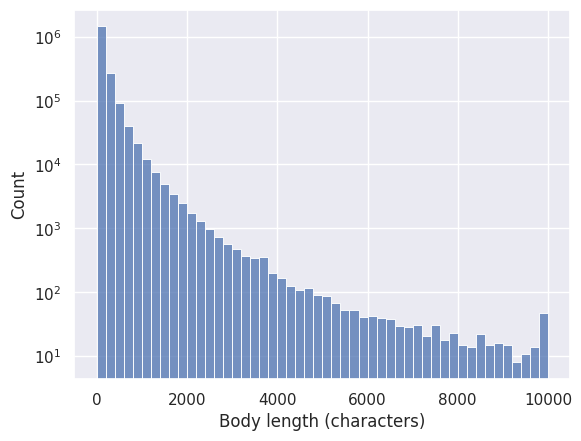

In [17]:
lengths = df[BODY].map(len)
ax = sns.histplot(
    lengths[lengths <= 10000],
    binwidth=200,
    # log_scale=True
)
ax.set(xlabel = "Body length (characters)")
ax.set(yscale = "log");

In [18]:
len(df[lengths >= 10000])

44

In [19]:
# Add a "Time range" column to a dataframe
import datetime

TIME_RANGE = "Time range"
"""Name of the column for storing time range"""

def with_time_range(df):
    dfs = []
    for time_range in config.time_ranges:
        start_time = datetime.datetime.combine(time_range.start_date, datetime.time(0, 0, 0))
        end_time = datetime.datetime.combine(time_range.end_date, datetime.time(0, 0, 0))
        filtered = df[(start_time <= df[TIME]) & (df[TIME] < end_time)].copy()
        filtered[TIME_RANGE] = time_range
        dfs.append(filtered)
    return pd.concat(dfs)

df = with_time_range(df)
df.head(n=3)

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body,Time range
84,26151686025,2010-01-01 00:01:14,WTF,3lzxf,t3_akc2y,t3_akc2y,1,0,"ok reddit, how long do you think it will be be...","TimeRange(start_date=2010-01-01, min=50000, hi..."
85,26151686057,2010-01-01 00:02:08,reddit.com,NaN,t1_c0i1e33,t3_akfoq,0,0,"for sure, for most it was earlier and for some...","TimeRange(start_date=2010-01-01, min=50000, hi..."
86,26151686346,2010-01-01 00:09:56,Cooking,3c248,t1_c0i13kw,t3_akdkr,2,0,"new year's *day*, yes. where i'm from, pork an...","TimeRange(start_date=2010-01-01, min=50000, hi..."


## Graphing distribution over time

<Axes: xlabel='time', ylabel='Count'>

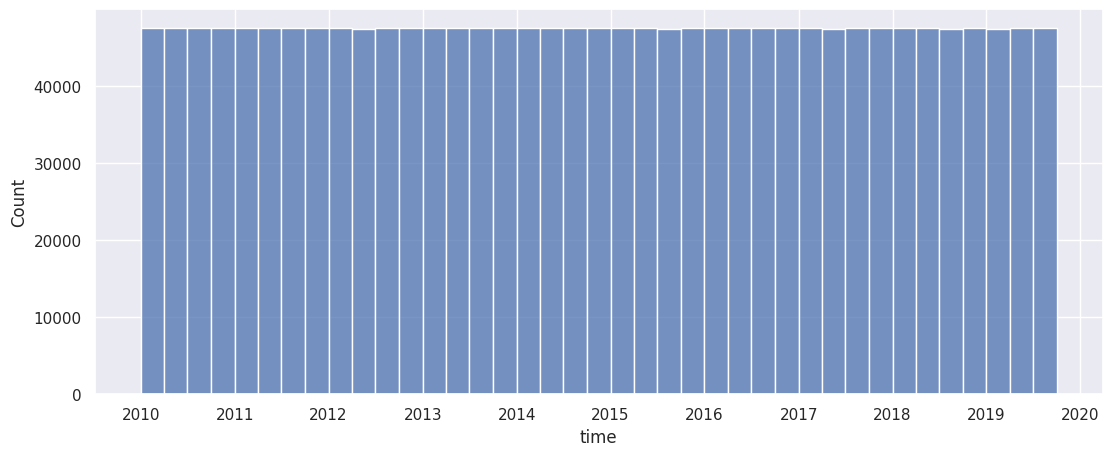

In [20]:
plt.figure(figsize=(13, 5))
sns.histplot(
    data=df,
    x=TIME,
    bins=[
        mpl.dates.date2num(time_range.start_date) for time_range in config.time_ranges
    ],
)

<Axes: xlabel='id', ylabel='hit_rate'>

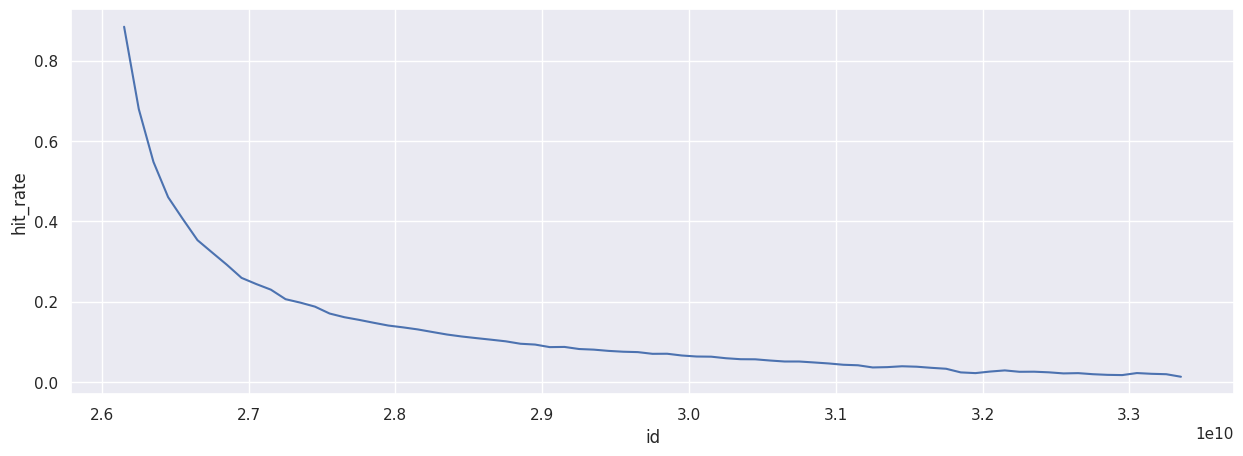

In [21]:
# Hit rates by ID
start = config.time_ranges[0].start_id
end = config.time_ranges[-1].end_id
step = int(1e8)

def get_rate(curr_id):
    next_id = curr_id + step
    num_hits = len(df[(curr_id <= df[ID]) & (df[ID] < next_id)])
    num_misses = len(misses[(misses > start) & (misses < next_id)])

    if num_misses == 0:
        return 0
    return num_hits / (num_hits + num_misses)

ids = np.arange(start, end, step)
rates = np.fromiter(map(get_rate, ids), dtype=np.dtype(np.float64))

rate_df = pd.DataFrame({ "id": ids, "hit_rate": rates })

plt.figure(figsize=(15, 5))
sns.lineplot(data=rate_df, x="id", y="hit_rate")

<Axes: xlabel='Date', ylabel='Hit rate'>

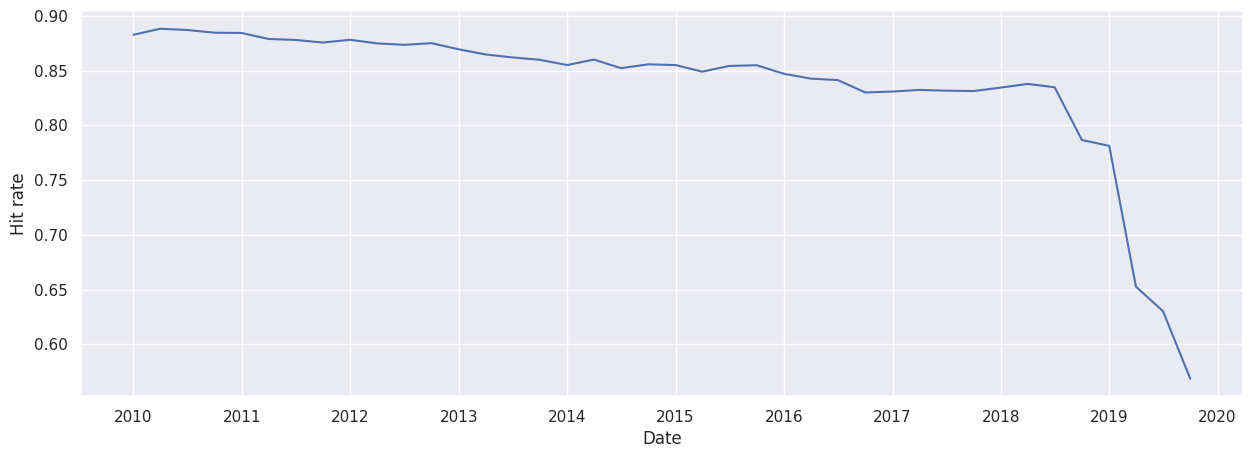

In [22]:
# Approximate hit rate for each time range
ranges = []
for time_range in config.time_ranges:
    num_hits = len(df[(time_range.start_id <= df[ID]) & (df[ID] <= time_range.end_id)])
    num_misses = len(misses[(time_range.start_id <= misses) & (misses <= time_range.end_id)])
    ranges.append([time_range.start_date, num_hits / (num_hits + num_misses)])

data = pd.DataFrame(ranges, columns=["Date", "Hit rate"])
plt.figure(figsize=(15, 5))
sns.lineplot(data, x="Date", y="Hit rate")

<Axes: xlabel='time', ylabel='Count'>

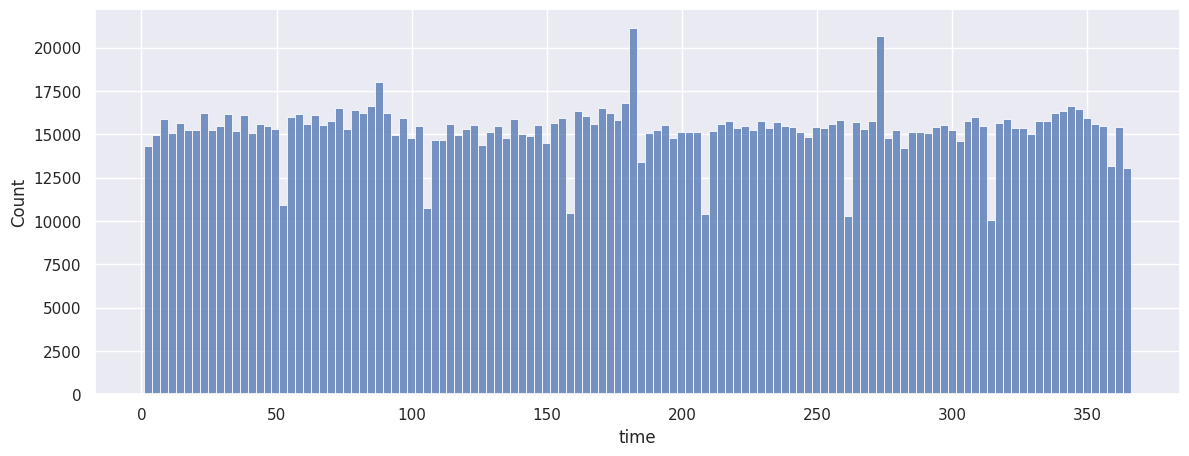

In [23]:
# Number of comments by day of year
plt.figure(figsize=(14, 5))
sns.histplot(data=df[TIME].apply(lambda t: int(t.strftime("%j"))))

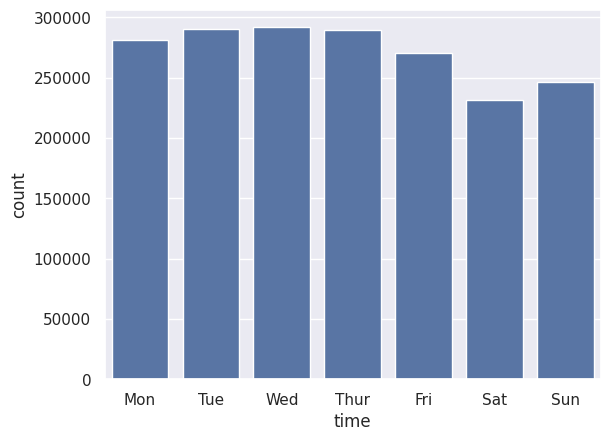

In [24]:
# Number of comments by day of week (0 = Monday)
g = sns.barplot(data=df[TIME].apply(lambda t: t.weekday()).value_counts())
g.set_xticks(
    g.get_xticks(),
    labels=[
        ["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"][tick]
        for tick in g.get_xticks()
    ],
);

### Are the IDs uniformly distributed?

Figure out if the IDs are uniformly distributed using the Kolmogorov-Smirnov test

TODO check if KS is the right test to use here. Alternatives (not sure if any of these are even applicable):
- Chi-square (we don't have a normal distribution though)
- Mann-Whitney U test
- Anderson-Darling

The fact that we're taking the first gotten comment as the start rather than the actual requested
start ID might screw things up but whatever

<Axes: xlabel='id', ylabel='Count'>

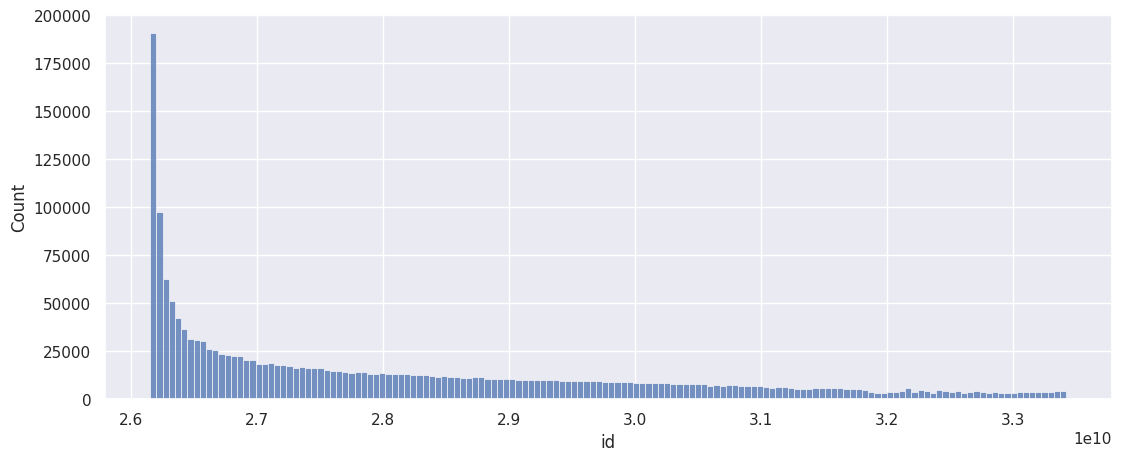

In [25]:
# Distribution of IDs

plt.figure(figsize=(13, 5))
sns.histplot(data=df[ID])

In [26]:
from scipy import stats

# Choose alpha of 0.05

ids_normalized = df[ID].map(lambda id: (id - first_id_actual) / (last_id - first_id_actual))
res = stats.ks_1samp(ids_normalized, stats.uniform.cdf)
if res.pvalue < 0.05:
    print("IDs are probably not uniformly distributed")
else:
    print("IDs are probably uniformly distributed")
res

IDs are probably not uniformly distributed


KstestResult(statistic=0.6435922724371967, pvalue=0.0, statistic_location=0.29181538184077443, statistic_sign=1)

In [27]:
# The earliest comment we have
df[df[ID] == df[ID].min()]

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body,Time range
84,26151686025,2010-01-01 00:01:14,WTF,3lzxf,t3_akc2y,t3_akc2y,1,0,"ok reddit, how long do you think it will be be...","TimeRange(start_date=2010-01-01, min=50000, hi..."


<Axes: >

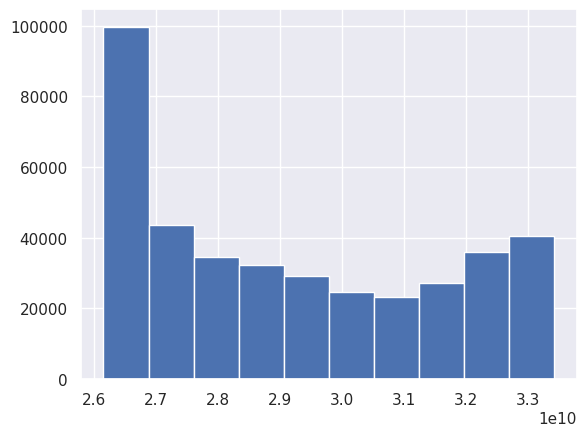

In [28]:
misses.hist()

<Axes: ylabel='Count'>

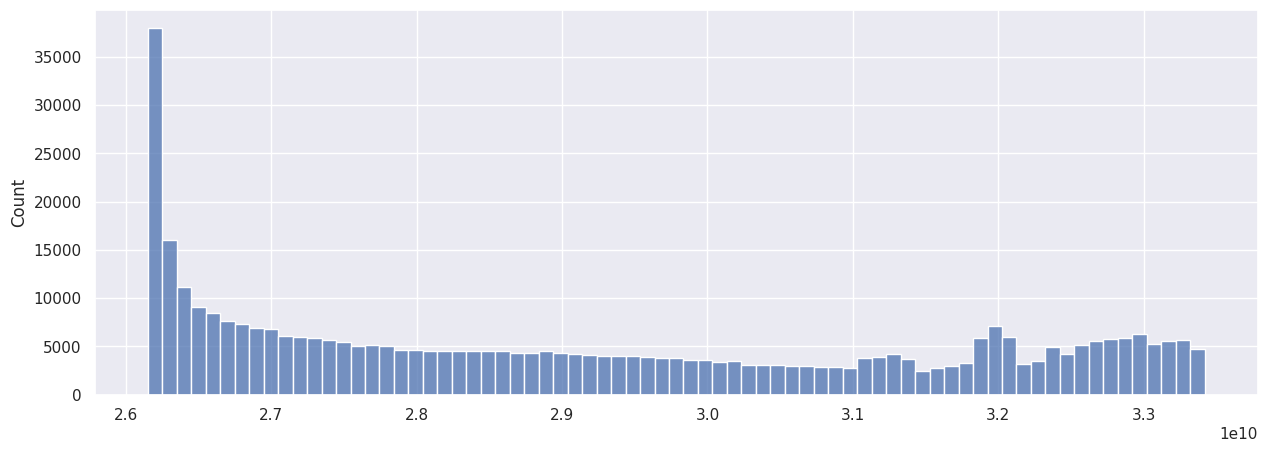

In [29]:
plt.figure(figsize=(15, 5))
misses_actual = misses[misses >= first_id_actual]
sns.histplot(misses_actual, binwidth=1e8)

<Axes: ylabel='Count'>

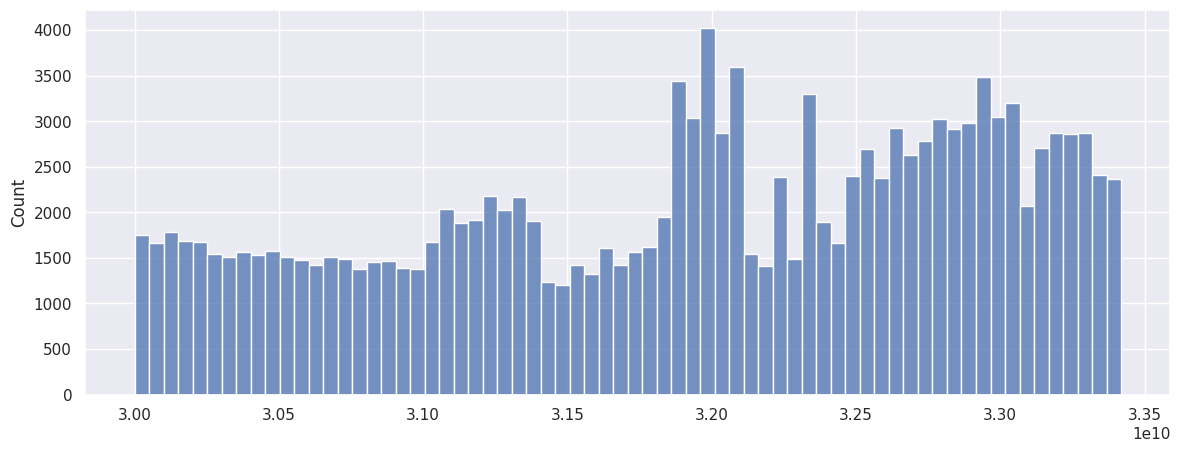

In [30]:
# Zoom in on the middle
# Note: The counts won't match the ones above because the bin width is different

# TODO How are you supposed to filter a series?
weirdos = misses[lambda id: id <= 3.75e10][lambda id: 3e10 <= id]

plt.figure(figsize=(14, 5))
sns.histplot(weirdos, binwidth=5e7)

In [31]:
# What portion of the requests we made actually returned something?
all = len(df) / (len(df) + len(misses))
# Same as above, but don't include requests for comments with IDs that were too low
exclude_invalid = len(df) / (len(df) + len(misses_actual))

all, exclude_invalid

(0.8296221676107236, 0.8296221676107236)

<Axes: xlabel='id', ylabel='rate'>

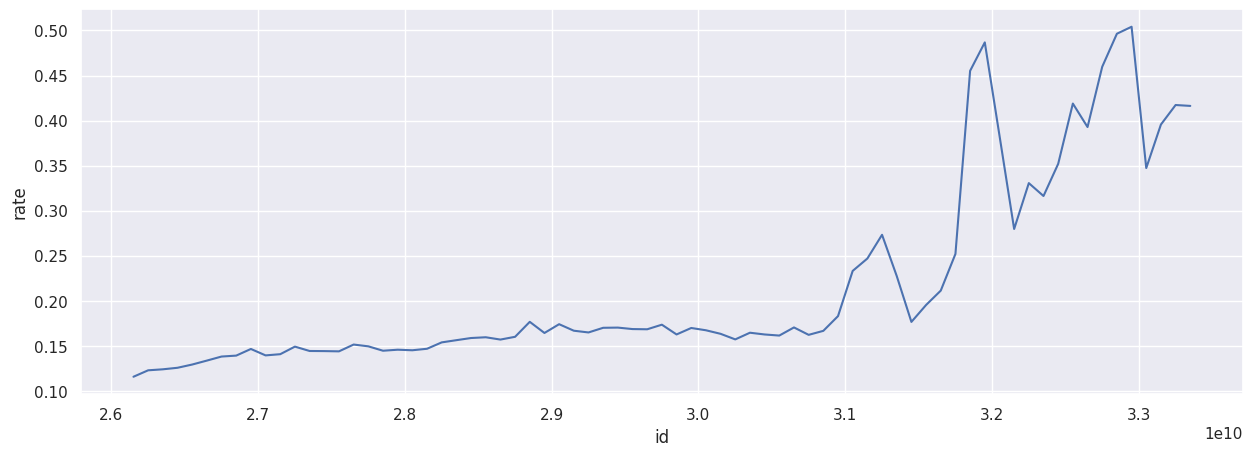

In [32]:
# Hit rate over time
start = first_id_actual
end = max(df.iloc[len(df) - 1][ID],
          misses.loc[len(misses) - 1])
step = int(1e8)

def get_rate(curr_id):
    next_id = curr_id + step
    hits = len(df[(curr_id <= df[ID]) & (df[ID] < next_id)])
    num_misses = len(misses[lambda id: curr_id <= id][lambda id: id < next_id])

    if num_misses == 0:
        return 0
    return num_misses / (hits + num_misses)

ids = np.arange(start, end, step)
rates = np.fromiter(map(get_rate, ids), dtype=np.dtype(np.float64))

rate_df = pd.DataFrame({ "id": ids, "rate": rates })

plt.figure(figsize=(15, 5))
sns.lineplot(data=rate_df, x="id", y="rate")

In [33]:
df[(3e10 <= df[ID]) & (df[ID] < 3.75e10)]

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body,Time range
1521313,30000000548,2018-01-03 15:46:31,CrappyDesign,kq14w,t3_7nwcxp,t3_7nwcxp,1,0,"i'm a bot, *bleep*, *bloop*. someone has linke...","TimeRange(start_date=2018-01-01, min=50000, hi..."
1521314,30000000648,2018-01-03 15:46:33,news,hpdj7,t1_ds54x1y,t3_7nuf0p,1,0,"> which is appointed by the mayor, i presume. ...","TimeRange(start_date=2018-01-01, min=50000, hi..."
1521315,30000004473,2018-01-03 15:47:54,RaiBlocks,ap05j,t3_7nxj2h,t3_7nxj2h,1,0,the consensus so far has been that the raibloc...,"TimeRange(start_date=2018-01-01, min=50000, hi..."
1521316,30000008262,2018-01-03 15:49:13,fireemblem,yplc2,t3_7nx5nt,t3_7nx5nt,28,0,"some of these actually fit, like saber's and i...","TimeRange(start_date=2018-01-01, min=50000, hi..."
1521317,30000009293,2018-01-03 15:49:34,conspiracy,o10qosf,t1_ds57b7x,t3_7nwklc,1,0,thank you,"TimeRange(start_date=2018-01-01, min=50000, hi..."
...,...,...,...,...,...,...,...,...,...,...
1900010,33418663200,2019-12-31 18:39:04,videos,14cwr7,t3_ei3zx5,t3_ei3zx5,-4,0,it's not so much the names that are funny but ...,"TimeRange(start_date=2019-10-01, min=50000, hi..."
1900011,33418693376,2019-12-31 18:46:49,GonewildGBUK,57nk6h9s,t3_ei9vhh,t3_ei9vhh,0,0,well if you need an extra cock in 2020 😜😈😈happ...,"TimeRange(start_date=2019-10-01, min=50000, hi..."
1900012,33418700835,2019-12-31 18:48:40,unpopularopinion,g8vguuw,t3_ei2udf,t3_ei2udf,1,0,it's also a stereotype that kids visit each pa...,"TimeRange(start_date=2019-10-01, min=50000, hi..."
1900013,33418710516,2019-12-31 18:51:06,AskReddit,lp3bf,t3_eiauoe,t3_eiauoe,2,0,"more ass, better ass","TimeRange(start_date=2019-10-01, min=50000, hi..."


In [34]:
from scipy import stats

# Choose alpha of 0.05

misses_normalized = (misses_actual - misses_actual.mean()) / misses_actual.std()

res = stats.ks_1samp(misses_normalized, stats.norm.cdf)
if res.pvalue < 0.05:
    print("Misses are probably not normally distributed")
else:
    print("Misses could be normally distributed")
res

Misses are probably not normally distributed


KstestResult(statistic=0.10711272388471044, pvalue=0.0, statistic_location=-0.673022862009497, statistic_sign=1)

# Subreddits

In [35]:
df[df[SR_NAME] == "reddit.com"]

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body,Time range
85,26151686057,2010-01-01 00:02:08,reddit.com,NaN,t1_c0i1e33,t3_akfoq,0,0,"for sure, for most it was earlier and for some...","TimeRange(start_date=2010-01-01, min=50000, hi..."
99,26151688760,2010-01-01 01:11:52,reddit.com,3bws6,t3_akfle,t3_akfle,1,0,>pacific mountain time zone\n\ngmt minus wtf?,"TimeRange(start_date=2010-01-01, min=50000, hi..."
100,26151688939,2010-01-01 01:16:14,reddit.com,3kbhj,t1_c0i0yep,t3_ak8iy,1,0,"once again, excellent suggestion.","TimeRange(start_date=2010-01-01, min=50000, hi..."
113,26151690758,2010-01-01 02:03:58,reddit.com,3ram5,t3_akgbg,t3_akgbg,1,0,genuine class,"TimeRange(start_date=2010-01-01, min=50000, hi..."
121,26151692913,2010-01-01 02:57:51,reddit.com,3sv0p,t3_ake99,t3_ake99,1,0,i could have sworn the world was doomed when g...,"TimeRange(start_date=2010-01-01, min=50000, hi..."
...,...,...,...,...,...,...,...,...,...,...
346446,26294850892,2011-10-28 17:37:25,reddit.com,5kdvp,t1_c2snvq4,t3_j6kft,1,0,im a slow person,"TimeRange(start_date=2011-10-01, min=50000, hi..."
348873,26296954303,2011-11-02 17:09:59,reddit.com,4w480,t3_lbnva,t3_lbnva,1,0,"wait! i got this!\n\nspanking? no, no! wanking!","TimeRange(start_date=2011-10-01, min=50000, hi..."
354947,26302381341,2011-11-14 16:52:02,reddit.com,37j4,t1_c2zljbv,t3_2mg72,3,0,fibonacci[7962]\n\n`4074803477 8997284660 1798...,"TimeRange(start_date=2011-10-01, min=50000, hi..."
361473,26308157761,2011-11-27 16:41:00,reddit.com,NaN,t1_c335gf8,t3_lfaqi,1,0,and you came back to tell me this? that is kin...,"TimeRange(start_date=2011-10-01, min=50000, hi..."


In [36]:
# Most popular subreddits
df[df[SR_NAME] != "reddit.com"][SR_NAME].value_counts().nlargest(20)

sr_name
AskReddit              192443
pics                    52891
funny                   41546
politics                39213
gaming                  34883
WTF                     25919
leagueoflegends         22466
worldnews               20831
IAmA                    20352
videos                  18055
atheism                 17779
nfl                     17112
todayilearned           16838
nba                     15419
AdviceAnimals           15163
trees                   14879
soccer                  13243
fffffffuuuuuuuuuuuu     11239
news                    11234
movies                  11136
Name: count, dtype: int64

In [11]:
# this looks at *count* rather than percent of comments from each subreddit
# todo fix that (oversampling thing)

data = df.groupby(TIME_RANGE).apply(lambda df: df[SR_NAME].value_counts(normalize=True).nlargest(5), include_groups=False)
data = data.to_frame("count").reset_index()
data[TIME_RANGE] = data[TIME_RANGE].apply(lambda tr: tr.start_date)

plt.figure(figsize=(15, 8))
ax = sns.lineplot(data, x=TIME_RANGE, y="count", hue=SR_NAME)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

NameError: name 'TIME_RANGE' is not defined

# Text cleaning

In [19]:
!pip install bs4 umarkdown

In [13]:
from bs4 import BeautifulSoup
from umarkdown import markdown

sample_df = df.sample(n=5000, random_state=123).reset_index(drop=True)

def parse_markdown(body: str):
    html = markdown(body)
    soup = BeautifulSoup(html, features="html.parser")
    return soup.get_text(" ").strip()

sample_df["parsed"] = sample_df[BODY].map(parse_markdown)
sample_df[[BODY, "parsed"]].head()

,body,parsed
0,Naw man. Twist those shits together. Hells 'o ...,Naw man. Twist those shits together. Hells 'o ...
1,Nobody will care about you not making posts / ...,Nobody will care about you not making posts / ...
2,"List cleaning services can be expensive, and a...","List cleaning services can be expensive, and a..."
3,I believe in evolution and not creationism. Ho...,I believe in evolution and not creationism. Ho...
4,So much potential for really unpleasant jokes ...,So much potential for really unpleasant jokes ...


In [33]:
from nltk.tokenize.casual import TweetTokenizer
import re
import unicodedata

tokenizer = TweetTokenizer()


def casual_tokenize(text: str) -> list[str]:
    text = unicodedata.normalize("NFKD", text)
    text = re.sub("[uU]/[A-Za-z_-]+", " ", text)
    text = re.sub("[rR]/[A-Za-z_.-]+", " ", text)
    text = text.replace("\n", " ")
    text = text.replace(r"\n", " ")
    # Kind of a dumb way to remove links but I'm like 90% sure it works
    no_links = [
        tok for tok in tokenizer.tokenize(text) if not re.match("https?://", tok)
    ]
    # Remove all tokens that only contain non-word characters
    no_symbol_tokens = [
        tok for tok in tokenizer.tokenize(text) if re.match("[A-Za-z]", tok)
    ]
    return no_symbol_tokens


sample_df["casual_tokenized"] = sample_df["parsed"].map(casual_tokenize)

In [30]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# Uncomment this the first time you run this code block
# nltk.download("wordnet")
# nltk.download('averaged_perceptron_tagger_eng')

lemmatizer = WordNetLemmatizer()

tokens = casual_tokenize("They're going to the mall")
tags = pos_tag(tokens)

def treebank_tag_to_wordnet_tag(tag: str):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# TODO this doesn't handle contractions, use spaCy instead
[lemmatizer.lemmatize(word, treebank_tag_to_wordnet_tag(tag)) for word, tag in tags]

["They're", 'go', 'to', 'the', 'mall']

# N-grams

In [101]:
import itertools

bigrams = nltk.bigrams(sample_df["casual_tokenized"].explode())
trigrams = nltk.trigrams(sample_df["casual_tokenized"].explode())
fdist = nltk.FreqDist(itertools.chain(bigrams, trigrams))
ngram_df = pd.DataFrame(
    [
        [ngram, fdist[ngram]]
        for ngram in fdist
        if all(isinstance(tok, str) for tok in ngram)
    ],
    columns=["ngram", "freq"],
)
ngram_df

,ngram,freq
0,"(of, the)",523
1,"(in, the)",437
2,"(to, be)",278
3,"(on, the)",256
4,"(to, the)",239
...,...,...
240420,"(than, to, change)",1
240421,"(change, a, mama's)",1
240422,"(mama's, boy, Just)",1
240423,"(boy, Just, keep)",1


In [102]:
def relevant_ngram(ngram, keywords=keywords):
    for token in ngram:
        for kw in keywords:
            try:
                if kw in token:
                    return True
            except TypeError as e:
                print(kw, ngram)
                raise e
    return False


ngram_df[ngram_df["ngram"].map(lambda ngram: relevant_ngram(ngram, keywords=["anx", "abus"]))].head()

,ngram,freq
9851,"(anxiety, I)",2
10567,"(with, abusive)",2
10568,"(abusive, MIL)",2
17759,"(contact, with, abusive)",2
17760,"(with, abusive, MIL)",2
